In [1]:
#imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import clip
import matplotlib.pyplot as plt
import json
import glob

from PIL import Image

In [2]:
class SparseEncoder(nn.Module):
    def __init__(self, embed_dim, vocab_size, token_embedding):
        super().__init__()
        self.sparse_projection = nn.Linear(embed_dim, vocab_size)
        self.sparse_projection.weight = nn.Parameter(token_embedding.weight)
    
    def forward(self, dense_vec):
        logits = self.sparse_projection(dense_vec)
        lex_weights = torch.log1p(torch.relu(logits))
        return lex_weights

In [3]:
class encoded_vectors():
    def __init__(self, image_vectors, caption_vectors):

        self.images = image_vectors
        self.captions  = caption_vectors

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image = self.images[idx]
        caption = self.captions[idx]
        return image,caption

In [4]:
def test_sparse_performance(model, test_ims, test_cap):
    x, _ = test_ims.shape
    encoded_images = torch.empty(int(x/5), 49408)
    for i in range(0, len(test_ims), 5):
        encoded_images[int(i/5)] = model(test_ims[i])


    encoded_captions = torch.empty(int(x), 49408)
    for i in range(len(encoded_captions)):
        encoded_captions[i] = model(test_cap[i])   

    encoded_images = (encoded_images / encoded_images.norm(dim=-1, keepdim=True)).to(device)
    encoded_captions = encoded_captions / encoded_captions.norm(dim=-1, keepdim=True)

    recall_1 = []
    recall_5 = []
    recall_10 = []
    i = 0
    image_id = 0
    for text_feature in encoded_captions:
        similarity = (100.0 * text_feature.to(device) @ encoded_images.T).softmax(dim=-1)

        values, indices = similarity.topk(1)
        recall_1.append(image_id in indices)

        values, indices = similarity.topk(5)
        recall_5.append(image_id in indices)

        values, indices = similarity.topk(10)
        recall_10.append(image_id in indices)

        i += 1
        if i == 5:
            i = 0
            image_id += 1

    recall_1 = torch.Tensor(recall_1)
    recall_5 = torch.Tensor(recall_5)
    recall_10 = torch.Tensor(recall_10)
    
    return recall_1.mean(), recall_5.mean(), recall_10.mean()

In [5]:
def test_dense_performance(encoded_ims, encoded_caps):
    encoded_ims = encoded_ims[0::5] / encoded_ims[0::5].norm(dim=-1, keepdim=True)
    encoded_caps = encoded_caps / encoded_caps.norm(dim=-1, keepdim=True)

    recall_1 = []
    recall_5 = []
    recall_10 = []
    i = 0
    image_id = 0
    for text_feature in encoded_caps:
        similarity = (100.0 * text_feature.to(device) @ encoded_ims.T).softmax(dim=-1)

        values, indices = similarity.topk(1)
        recall_1.append(image_id in indices)

        values, indices = similarity.topk(5)
        recall_5.append(image_id in indices)

        values, indices = similarity.topk(10)
        recall_10.append(image_id in indices)

        i += 1
        if i == 5:
            i = 0
            image_id += 1

    recall_1 = torch.Tensor(recall_1)
    recall_5 = torch.Tensor(recall_5)
    recall_10 = torch.Tensor(recall_10)
    
    return recall_1.mean(), recall_5.mean(), recall_10.mean()

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32",device=device,jit=False)

checkpoint = torch.load("D:/thesis/Models/flickr30k trained/92.pt", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
embed_dim = model.text_projection.shape[1]
sparse_mlm = SparseEncoder(embed_dim, model.vocab_size, model.token_embedding).to(device)

In [51]:
#open the json file for annotations
f = open('datasets/flickr30k/dataset_flickr30k.json')
data = json.load(f)

# load all captions
caps = [x['sentences'] for x in data['images'] if x.get('split') == 'train']
test_caps = [x['sentences'] for x in data['images'] if x.get('split') == 'test']

files = []
test_files = []
for x in data['images']:
    if x.get('split') == 'train':
        files.append('datasets/flickr30k/train/' + x['filename'])
    
    elif x.get('split') == 'test':
        test_files.append('datasets/flickr30k/test/' + x['filename'])
            
captions = []
for x in caps:
    for y in x:
        captions.append(y)
        
test_captions = []
for x in test_caps:
    for y in x:
        test_captions.append(y)
    
captions = [x.get('raw') for x in captions]
test_captions = [x.get('raw') for x in test_captions]

# these captions are too long and need adjusting
captions[13035] = 'Four young adults sit outside on a wooden deck near a building around a small round table, while another person stands on the edge of the deck, leaning on the wooden railing, with the sun shining on one of them, one holding a cellphone out in front of himself and another holding a green and red soda can.'
captions[14580] = 'A man wearing a helmet, red pants with white and a white and red shirt is on a small bicycle using only his hands, while another man wearing a light blue shirt with dark blue trim and black pants with red stripes is standing nearby, gesturing toward the first man and holding a small figurine.'
captions[120165] = 'In this photo there is a man in a dirty white shirt and a black hat with yellow stained teeth, he looks happy and it appears that he is also repairing something.'
test_captions[3905] = 'Two boys are looking upwards with their arms streteched to the sky, the boy on the left is wearing a blue vest jacket with a gray shirt, black jogging pants and a hat, and the boy on the right is wearing a silver vest jacket, with blue long-sleeved undershirt, gray pants, black tennis shoes and has black short hair and glasses.'


In [52]:
files = files[0:1000]
captions = captions[0:5000]

In [63]:
L = len(files)
batch_size = 256
with torch.no_grad():
    encoded_images = torch.Tensor().to(device)
    for i in range(0, L, batch_size):
        print(i,"/",L, end='\r')
        images = torch.Tensor().to(device)
        for x in range(batch_size):
            if (i + x) < L:
                image = preprocess(Image.open(files[i+x])).to(device)
                images = torch.cat((images, image.reshape(1,3,224,224)), 0)
            
        ims = model.encode_image(images)
        encoded_images = torch.cat((encoded_images, ims), 0)      
        
print("")
print("done")

768 / 1000
done


In [11]:
text = clip.tokenize(captions).to(device)

# encode captions
text_features = torch.Tensor().to(device)
with torch.no_grad():
    for i in range(0, len(text), 128):
        ts = model.encode_text(text[i:i+128])
        text_features = torch.cat((text_features, ts), 0)
        if (i%256) == 0:
            print(i,"/",len(text), end='\r')

print("")
print("done")

256 / 500
done


In [9]:
test_images = torch.Tensor().to(device)
with torch.no_grad():
    for j in range(0, len(test_files), 64):
        images = torch.Tensor().to(device)
        for x in range(64):
            if (j + x) < len(test_files):
                image = preprocess(Image.open(test_files[j+x])).to(device)
                images = torch.cat((images, image.reshape(1,3,224,224).repeat(5, 1, 1, 1)), 0)
        
        ims = model.encode_image(images)
        test_images = torch.cat((test_images, ims), 0)
        if (j%128) == 0:
            print(j,"/",len(test_files), end='\r')
        
print("")
print("done")

896 / 1000
done


In [10]:
text = clip.tokenize(test_captions).to(device)

# encode captions
test_features = torch.Tensor().to(device)
with torch.no_grad():
    for i in range(0, len(text), 128):
        ts = model.encode_text(text[i:i+128])
        test_features = torch.cat((test_features, ts), 0)
        if (i%256) == 0:
            print(i,"/",len(text), end='\r')

print("")
print("done")

4864 / 5000 / 5000 / 5000
done


In [14]:
batchsize = 64

dataset = encoded_vectors(encoded_images, text_features)
train_dataloader = DataLoader(dataset, batch_size = batchsize, shuffle=True)

In [15]:
for test in dataset:
    print(test)
    break

(tensor([ 2.3926e-02,  3.6963e-01, -7.7026e-02, -3.9331e-01,  2.9022e-02,
        -4.7394e-02,  5.5664e-01,  1.0095e-01,  4.3213e-02, -1.5601e-01,
         1.7993e-01, -2.0593e-01, -1.0771e+00,  1.6809e-01, -8.1299e-02,
        -1.3379e-01, -1.3770e+00,  1.4233e-01,  2.3636e-02,  5.0751e-02,
         7.5977e-01, -1.6443e-01, -8.8501e-02, -1.4148e-01,  5.0684e-01,
        -2.1106e-01,  5.9540e-02,  8.0078e-02,  2.7661e-01, -2.5757e-01,
        -4.0649e-01,  2.0374e-01,  1.7126e-01, -3.7994e-02,  6.8750e-01,
        -4.7028e-02, -1.5796e-01,  2.3438e-01,  6.2842e-01,  2.3608e-01,
        -1.2329e-01,  8.1360e-02, -2.6440e-01, -5.9229e-01,  1.4160e-01,
         7.0020e-01,  5.3174e-01,  3.5522e-01, -5.1904e-01,  5.5322e-01,
        -5.4535e-02,  5.0684e-01,  2.9831e-02, -1.3916e-01, -1.4191e-02,
         5.2734e-02, -1.8323e-01, -9.7595e-02, -6.7871e-01, -1.0541e-01,
         3.6328e-01, -1.0400e-01,  1.0046e-01,  2.6270e-01,  1.6858e-01,
        -3.0835e-01, -1.1253e-02,  1.6025e+00, -1.

epoch: 49 batch: 2250 / 2265
done


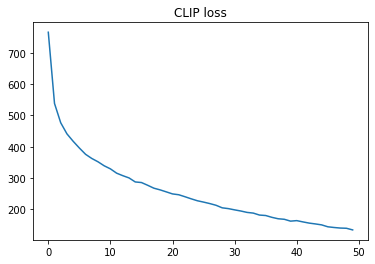

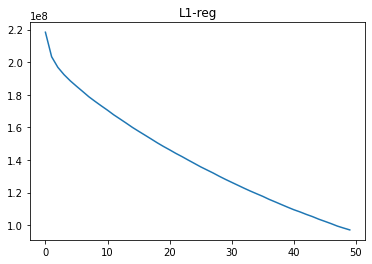

In [15]:
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sparse_mlm.parameters(), lr=1e-6,betas=(0.9,0.98),eps=1e-6,weight_decay=0.001)

epochs = 50
totalbatches = int(len(dataset) / batchsize)
logit_scale = model.logit_scale.exp().item()
alpha = 1
lambda1 = 0
cliplosses = []
sparselosses = []
test_loss = [[], [], []]
for epoch in range(0, epochs):
    i = 0
    cliploss_total = 0
    sparseloss_total = 0
    for batch in train_dataloader:
        if i % 25 == 0:
            print("epoch:", epoch, "batch:", i, "/", totalbatches, end='\r')
       
        optimizer.zero_grad()
        ims, caps = batch
        
        # sparse encoding
        sparse_ims = sparse_mlm(ims)
        sparse_caps = sparse_mlm(caps)
        
        l1_regularization = torch.norm(sparse_ims, 1) + torch.norm(sparse_caps, 1)

        # determine logits
        sparse_ims = sparse_ims / sparse_ims.norm(dim=-1, keepdim=True)
        sparse_caps = sparse_caps / sparse_caps.norm(dim=-1, keepdim=True)
        logits_per_image = logit_scale * sparse_ims @ sparse_caps.t()
        logits_per_text = logits_per_image.t()
        
        # compute losses
        ground_truth = torch.arange(len(ims),dtype=torch.long,device=device)
        
        clip_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
        total_loss = alpha * clip_loss + lambda1 * l1_regularization
        
        cliploss_total += clip_loss.item()
        sparseloss_total += l1_regularization.item()
    
        total_loss.backward()

        optimizer.step()
        i+=1
        
    cliplosses.append(cliploss_total)
    sparselosses.append(sparseloss_total)
    
    rec1,rec5,rec10 = test_sparse_performance(sparse_mlm, test_images, test_features)
    test_loss[0].append(rec1)
    test_loss[1].append(rec5)
    test_loss[2].append(rec10)
    
"""
    torch.save({
        'epoch':epoch,
        'model_state_dict': sparse_mlm.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"Models/" + str(epoch) + ".pt")
"""      
print("")
print("done")

plt.plot(cliplosses)
plt.title('CLIP loss')
plt.show()

plt.plot(sparselosses)
plt.title('L1-reg')
plt.show()

In [19]:
test_loss

[[tensor(0.6638),
  tensor(0.6752),
  tensor(0.6818),
  tensor(0.6864),
  tensor(0.6894),
  tensor(0.6904),
  tensor(0.6952),
  tensor(0.6976),
  tensor(0.6980),
  tensor(0.6974),
  tensor(0.7008),
  tensor(0.6990),
  tensor(0.7020),
  tensor(0.7038),
  tensor(0.7038),
  tensor(0.7044),
  tensor(0.7054),
  tensor(0.7054),
  tensor(0.7046),
  tensor(0.7062),
  tensor(0.7054),
  tensor(0.7064),
  tensor(0.7048),
  tensor(0.7044),
  tensor(0.7072),
  tensor(0.7052),
  tensor(0.7050),
  tensor(0.7076),
  tensor(0.7064),
  tensor(0.7028),
  tensor(0.7038),
  tensor(0.7048),
  tensor(0.7064),
  tensor(0.7036),
  tensor(0.7064),
  tensor(0.7054),
  tensor(0.7076),
  tensor(0.7060),
  tensor(0.7084),
  tensor(0.7088),
  tensor(0.7098),
  tensor(0.7078),
  tensor(0.7082),
  tensor(0.7080),
  tensor(0.7052),
  tensor(0.7044),
  tensor(0.7062),
  tensor(0.7048),
  tensor(0.7050),
  tensor(0.7054)],
 [tensor(0.8910),
  tensor(0.9010),
  tensor(0.9048),
  tensor(0.9080),
  tensor(0.9086),
  tensor(

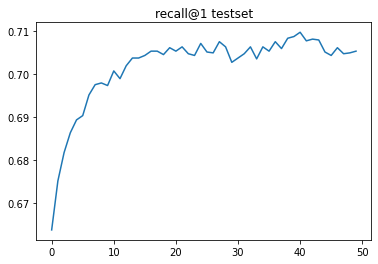

In [16]:
plt.plot(test_loss[0])
plt.title('recall@1 testset')
plt.show()

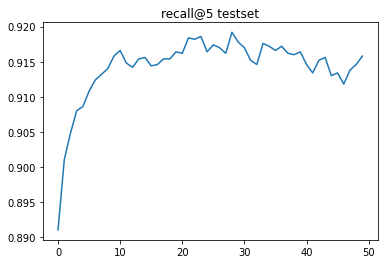

In [17]:
plt.plot(test_loss[1])
plt.title('recall@5 testset')
plt.show()

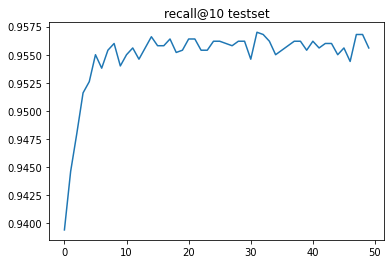

In [18]:
plt.plot(test_loss[2])
plt.title('recall@10 testset')
plt.show()

In [71]:
test_vec = text_features[0]

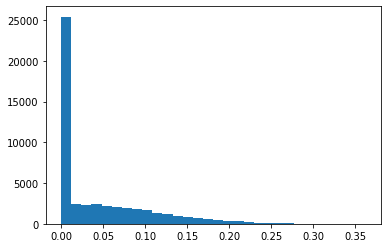

tensor(2102.7783, device='cuda:0', grad_fn=<NormBackward1>)


In [58]:
# before training
test_spar = sparse_mlm(test_vec)

plt.hist(test_spar.cpu().detach().numpy(), bins=30)
plt.show()

l1_regularization = torch.norm(test_spar, 1)
print(l1_regularization)

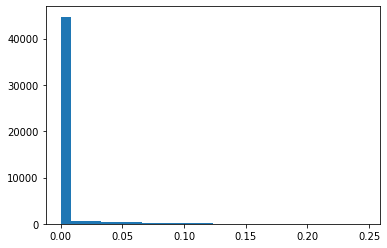

tensor(245.2794, device='cuda:0', grad_fn=<NormBackward1>)


In [72]:
# after training
test_spar = sparse_mlm(test_vec)

plt.hist(test_spar.cpu().detach().numpy(), bins=30)
plt.show()

l1_regularization = torch.norm(test_spar, 1)
print(l1_regularization)

In [27]:
torch.numel(test_spar[test_spar == 0])

49042

In [28]:
test_spar.shape

torch.Size([49408])

In [29]:
#open the json file for annotations
f = open("C:/Users/Lalashops/Desktop/MasterThesis/random images/vocab.json", encoding = 'utf-8')
vocab = json.load(f)

In [32]:
torch.topk(test_spar, 10).indices[0]

tensor(9382, device='cuda:0')

In [35]:
for idx in torch.topk(test_spar, 10).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], test_spar[idx])

nature tensor(0.1691, device='cuda:0', grad_fn=<SelectBackward0>)
ðŁĴŀðŁĴŀ</w> tensor(0.1658, device='cuda:0', grad_fn=<SelectBackward0>)
honouring</w> tensor(0.1613, device='cuda:0', grad_fn=<SelectBackward0>)
thelove</w> tensor(0.1548, device='cuda:0', grad_fn=<SelectBackward0>)
anism</w> tensor(0.1444, device='cuda:0', grad_fn=<SelectBackward0>)
living tensor(0.1435, device='cuda:0', grad_fn=<SelectBackward0>)
month tensor(0.1427, device='cuda:0', grad_fn=<SelectBackward0>)
complain</w> tensor(0.1419, device='cuda:0', grad_fn=<SelectBackward0>)
antique</w> tensor(0.1394, device='cuda:0', grad_fn=<SelectBackward0>)
jerome</w> tensor(0.1368, device='cuda:0', grad_fn=<SelectBackward0>)


In [36]:
captions[0]

'Two young guys with shaggy hair look at their hands while hanging out in the yard.'

In [37]:
test1 = captions[2]

In [41]:
test1_encoded = model.encode_text(clip.tokenize(test1).to(device))

In [50]:
test1_encoded = test1_encoded.type('torch.cuda.FloatTensor')

'torch.cuda.FloatTensor'

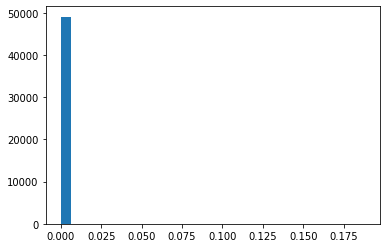

tensor(14.1397, device='cuda:0', grad_fn=<NormBackward1>)


In [57]:
# after training
test_spar2 = sparse_mlm(test1_encoded.reshape(512))

plt.hist(test_spar2.cpu().detach().numpy(), bins=30)
plt.show()

l1_regularization = torch.norm(test_spar2, 1)
print(l1_regularization)

In [59]:
torch.topk(test_spar2, 10).indices[0]

tensor(39782, device='cuda:0')

In [60]:
for idx in torch.topk(test_spar2, 10).indices:
    print(list(vocab.keys())[list(vocab.values()).index(idx)], test_spar2[idx])

summon</w> tensor(0.1883, device='cuda:0', grad_fn=<SelectBackward0>)
montenegro</w> tensor(0.1666, device='cuda:0', grad_fn=<SelectBackward0>)
lister</w> tensor(0.1508, device='cuda:0', grad_fn=<SelectBackward0>)
mantra</w> tensor(0.1470, device='cuda:0', grad_fn=<SelectBackward0>)
wellness tensor(0.1449, device='cuda:0', grad_fn=<SelectBackward0>)
discarded</w> tensor(0.1421, device='cuda:0', grad_fn=<SelectBackward0>)
pena</w> tensor(0.1309, device='cuda:0', grad_fn=<SelectBackward0>)
niche</w> tensor(0.1279, device='cuda:0', grad_fn=<SelectBackward0>)
sense</w> tensor(0.1257, device='cuda:0', grad_fn=<SelectBackward0>)
observ tensor(0.1214, device='cuda:0', grad_fn=<SelectBackward0>)


In [38]:
test1

'Two men in green shirts are standing in a yard.'

In [18]:
rec1,rec5,rec10 = test_dense_performance(encoded_images, text_features)

print(rec1)
print(rec5)
print(rec10)

tensor(0.2911)
tensor(0.5214)
tensor(0.6209)


In [19]:
rec1,rec5,rec10 = test_sparse_performance(sparse_mlm, encoded_images, text_features)

print(rec1)
print(rec5)
print(rec10)

tensor(0.4504)
tensor(0.7118)
tensor(0.7936)


In [34]:
rec1,rec5,rec10 = test_sparse_performance(sparse_mlm, encoded_images, text_features)

print(rec1)
print(rec5)
print(rec10)

tensor(0.7346)
tensor(0.9622)
tensor(0.9840)


In [19]:
rec1,rec5,rec10 = test_dense_performance(test_images, test_features)

print(rec1)
print(rec5)
print(rec10)

tensor(0.6724)
tensor(0.8908)
tensor(0.9424)


In [31]:
rec1,rec5,rec10 = test_sparse_performance(sparse_mlm, test_images, test_features)

print(rec1)
print(rec5)
print(rec10)

tensor(0.4264)
tensor(0.6836)
tensor(0.7680)


In [21]:
rec1,rec5,rec10 = test_sparse_performance(sparse_mlm, test_images, test_features)

print(rec1)
print(rec5)
print(rec10)

tensor(0.4306)
tensor(0.7138)
tensor(0.8096)


In [13]:
rec1,rec5,rec10 = test_sparse_performance(sparse_mlm, test_images, test_features)

print(rec1)
print(rec5)
print(rec10)

cpu
503101952
503299584
503497216
503694848
503892480
504090112
504287744
504485376
504683008
504880640
505078272
505275904
505473536
505671168
505868800
506066432
506264064
506461696
506659328
506856960
507054592
507252224
507449856
507647488
507845120
508042752
508240384
508438016
508635648
508833280
509030912
509228544
509426176
509623808
509821440
510019072
510216704
510414336
510611968
510809600
511007232
511204864
511402496
511600128
511797760
511995392
512193024
512390656
512588288
512785920
512983552
513181184
513378816
513576448
513774080
513971712
514169344
514366976
514564608
514762240
514959872
515157504
515355136
515552768
515750400
515948032
516145664
516343296
516540928
516738560
516936192
517133824
517331456
517529088
517726720
517924352
518121984
518319616
518517248
518714880
518912512
519110144
519307776
519505408
519703040
519900672
520098304
520295936
520493568
520691200
520888832
521086464
521284096
521481728
521679360
521876992
522074624
522272256
522469888
522667

669112832
669310464
669508096
669705728
669903360
670100992
670298624
670496256
670693888
670891520
671089152
671286784
671484416
671682048
671879680
672077312
672274944
672472576
672670208
672867840
673065472
673263104
673460736
673658368
673856000
674053632
674251264
674448896
674646528
674844160
675041792
675239424
675437056
675634688
675832320
676029952
676227584
676425216
676622848
676820480
677018112
677215744
677413376
677611008
677808640
678006272
678203904
678401536
678599168
678796800
678994432
679192064
679389696
679587328
679784960
679982592
680180224
680377856
680575488
680773120
680970752
681168384
681366016
681563648
681761280
681958912
682156544
682354176
682551808
682749440
682947072
683144704
683342336
683539968
683737600
683935232
684132864
684330496
684528128
684725760
684923392
685121024
685318656
685516288
685713920
685911552
686109184
686306816
686504448
686702080
686899712
687097344
687294976
687492608
687690240
687887872
688085504
688283136
688480768
688678400


838681088
838878720
839076352
839273984
839471616
839669248
839866880
840064512
840262144
840459776
840657408
840855040
841052672
841250304
841447936
841645568
841843200
842040832
842238464
842436096
842633728
842831360
843028992
843226624
843424256
843621888
843819520
844017152
844214784
844412416
844610048
844807680
845005312
845202944
845400576
845598208
845795840
845993472
846191104
846388736
846586368
846784000
846981632
847179264
847376896
847574528
847772160
847969792
848167424
848365056
848562688
848760320
848957952
849155584
849353216
849550848
849748480
849946112
850143744
850341376
850539008
850736640
850934272
851131904
851329536
851527168
851724800
851922432
852120064
852317696
852515328
852712960
852910592
853108224
853305856
853503488
853701120
853898752
854096384
854294016
854491648
854689280
854886912
855084544
855282176
855479808
855677440
855875072
856072704
856270336
856467968
856665600
856863232
857060864
857258496
857456128
857653760
857851392
858049024
858246656


1006668288
1006865920
1007063552
1007261184
1007458816
1007656448
1007854080
1008051712
1008249344
1008446976
1008644608
1008842240
1009039872
1009237504
1009435136
1009632768
1009830400
1010028032
1010225664
1010423296
1010620928
1010818560
1011016192
1011213824
1011411456
1011609088
1011806720
1012004352
1012201984
1012399616
1012597248
1012794880
1012992512
1013190144
1013387776
1013585408
1013783040
1013980672
1014178304
1014375936
1014573568
1014771200
1014968832
1015166464
1015364096
1015561728
1015759360
1015956992
1016154624
1016352256
1016549888
1016747520
1016945152
1017142784
1017340416
1017538048
1017735680
1017933312
1018130944
1018328576
1018526208
1018723840
1018921472
1019119104
1019316736
1019514368
1019712000
1019909632
1020107264
1020304896
1020502528
1020700160
1020897792
1021095424
1021293056
1021490688
1021688320
1021885952
1022083584
1022281216
1022478848
1022676480
1022874112
1023071744
1023269376
1023467008
1023664640
1023862272
1024059904
1024257536
1024455168

1173272064
1173469696
1173667328
1173864960
1174062592
1174260224
1174457856
1174655488
1174853120
1175050752
1175248384
1175446016
1175643648
1175841280
1176038912
1176236544
1176434176
1176631808
1176829440
1177027072
1177224704
1177422336
1177619968
1177817600
1178015232
1178212864
1178410496
1178608128
1178805760
1179003392
1179201024
1179398656
1179596288
1179793920
1179991552
1180189184
1180386816
1180584448
1180782080
1180979712
1181177344
1181374976
1181572608
1181770240
1181967872
1182165504
1182363136
1182560768
1182758400
1182956032
1183153664
1183351296
1183548928
1183746560
1183944192
1184141824
1184339456
1184537088
1184734720
1184932352
1185129984
1185327616
1185525248
1185722880
1185920512
1186118144
1186315776
1186513408
1186711040
1186908672
1187106304
1187303936
1187501568
1187699200
1187896832
1188094464
1188292096
1188489728
1188687360
1188884992
1189082624
1189280256
1189477888
1189675520
1189873152
1190070784
1190268416
1190466048
1190663680
1190861312
1191058944

1341654528
1341852160
1342049792
1342247424
1342445056
1342642688
1342840320
1343037952
1343235584
1343433216
1343630848
1343828480
1344026112
1344223744
1344421376
1344619008
1344816640
1345014272
1345211904
1345409536
1345607168
1345804800
1346002432
1346200064
1346397696
1346595328
1346792960
1346990592
1347188224
1347385856
1347583488
1347781120
1347978752
1348176384
1348374016
1348571648
1348769280
1348966912
1349164544
1349362176
1349559808
1349757440
1349955072
1350152704
1350350336
1350547968
1350745600
1350943232
1351140864
1351338496
1351536128
1351733760
1351931392
1352129024
1352326656
1352524288
1352721920
1352919552
1353117184
1353314816
1353512448
1353710080
1353907712
1354105344
1354302976
1354500608
1354698240
1354895872
1355093504
1355291136
1355488768
1355686400
1355884032
1356081664
1356279296
1356476928
1356674560
1356872192
1357069824
1357267456
1357465088
1357662720
1357860352
1358057984
1358255616
1358453248
1358650880
1358848512
1359046144
1359243776
1359441408

1511222784
1511420416
1511618048
1511815680
1512013312
1512210944
1512408576
1512606208
1512803840
1513001472
1513199104
1513396736
1513594368
1513792000
1513989632
1514187264
1514384896
1514582528
1514780160
1514977792
1515175424
1515373056
1515570688
1515768320
1515965952
1516163584
1516361216
1516558848
1516756480
1516954112
1517151744
1517349376
1517547008
1517744640
1517942272
1518139904
1518337536
1518535168
1518732800
1518930432
1519128064
1519325696
1519523328
1519720960
1519918592
1520116224
1520313856
1520511488
1520709120
1520906752
1521104384
1521302016
1521499648
1521697280
1521894912
1522092544
1522290176
1522487808
1522685440
1522883072
1523080704
1523278336
1523475968
1523673600
1523871232
1524068864
1524266496
1524464128
1524661760
1524859392
1525057024
1525254656
1525452288
1525649920
1525847552
1526045184
1526242816
1526440448
1526638080
1526835712
1527033344
1527230976
1527428608
1527626240
1527823872
1528021504
1528219136
1528416768
1528614400
1528812032
1529009664

1677233664
1677431296
1677628928
1677826560
1678024192
1678221824
1678419456
1678617088
1678814720
1679012352
1679209984
1679407616
1679605248
1679802880
1680000512
1680198144
1680395776
1680593408
1680791040
1680988672
1681186304
1681383936
1681581568
1681779200
1681976832
1682174464
1682372096
1682569728
1682767360
1682964992
1683162624
1683360256
1683557888
1683755520
1683953152
1684150784
1684348416
1684546048
1684743680
1684941312
1685138944
1685336576
1685534208
1685731840
1685929472
1686127104
1686324736
1686522368
1686720000
1686917632
1687115264
1687312896
1687510528
1687708160
1687905792
1688103424
1688301056
1688498688
1688696320
1688893952
cpu
1688893952
cuda:0
cpu
1886525952
tensor(0.5270)
tensor(0.7894)
tensor(0.8592)


In [13]:
test_features

tensor([[-0.2269,  0.4604,  0.0879,  ..., -0.0014,  0.0213, -0.6221],
        [-0.1140,  0.1544,  0.1340,  ...,  0.3579, -0.0752, -0.4661],
        [-0.0629,  0.3931, -0.0260,  ...,  0.1616,  0.0503, -0.4751],
        ...,
        [ 0.0135,  0.2279, -0.2080,  ...,  0.1257, -0.2000,  0.0092],
        [-0.0342, -0.0309, -0.4868,  ...,  0.4126,  0.0249, -0.2135],
        [-0.1073, -0.0107, -0.2837,  ..., -0.0889,  0.2191, -0.3015]],
       device='cuda:0')